# How to Design Experiments

## Stroop Task

In the Stroop task (Stroop, 1935), participants are typically asked to name the color in which a color word is displayed (e.g., say ``green'' to the word <font color="green">RED</font> displayed in green). Here, we consider the Stroop color naming experiment with two regular factors: the color factor representing the color in which the stimulus is displayed, and having four levels:  red, blue, green, brown; and the word factor representing the word itself, also having four levels corresponding to each of the colors (see Figure below). On a given trial, one level from each factor is used to generate the stimulus, and the participant is required to respond to the color factor, indicating the color in which the word was displayed. For instance, they may be required to press the left arrow key if the word was displayed in red, the right arrow key if it was in green, the up arrow key if it was in blue, the down arrow if it was in brown.  This results in a response factor with four levels: left, right, up and down.

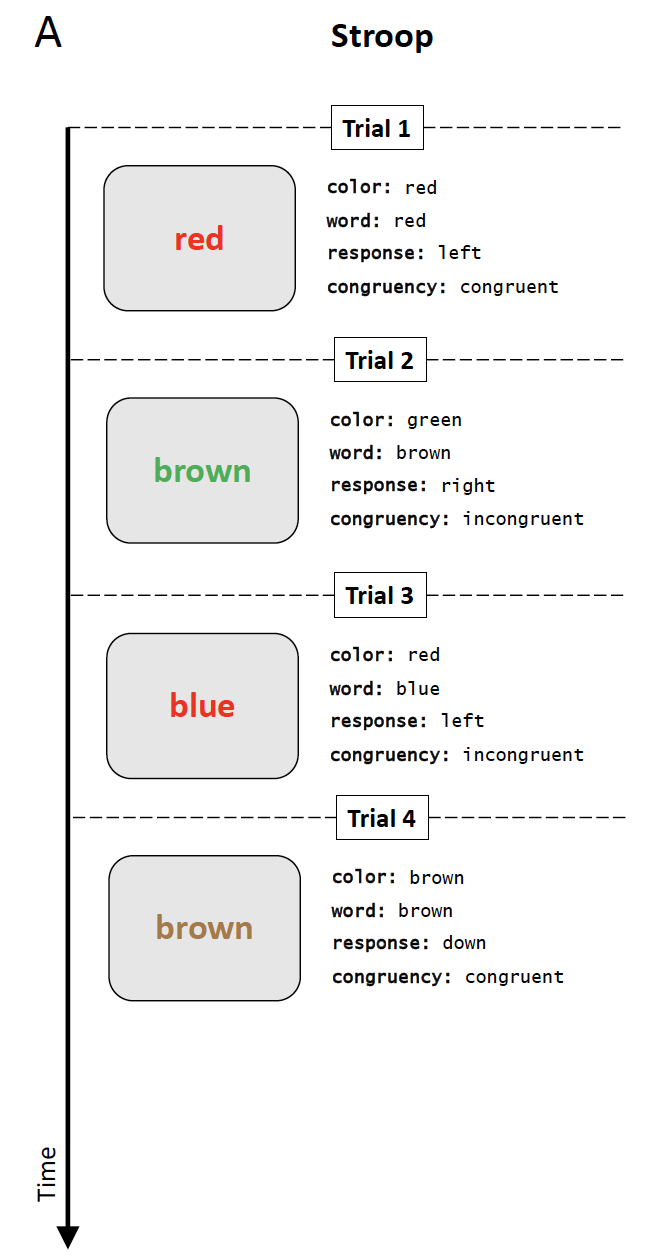

In the general case, an experimenter may want to ensure that each color is paired with each word. This could be achieved by crossing all colors with all words. The full crossing of colors and words includes conditions in which the color and the word are the same (congruent; e.g., the word <font color="red">RED</font> displayed in red), as well as conditions in which they are different (incongruent; e.g., the written word <font color="red">GREEN</font> displayed in red). Together, the two conditions define the congruency of a trial. In this particular experiment, we wish to pair each color with each word, subject to the constraint that only incongruent trials are included. Finally, we wish to generate a minimum of 20 experiment trials. For the ease of the reader, we interleave each chunk of code with an explanation of what it does for the first walkthrough example.

### Importing Modules

We begin with installing SweetPea and the relevant modules:

In [8]:
%%capture

# INSTALL AND IMPORT MODULES

%pip install sweetpea

from sweetpea import (
    Factor, DerivedLevel, WithinTrial, Transition, AtMostKInARow,
    CrossBlock, synthesize_trials, print_experiments, tabulate_experiments,
    CMSGen, MinimumTrials
)

These modules are needed to specify regular and derived factors, implement design constraints, and generate, sample, print, tabulate and export the final experiment.

We continue with defining the two basic factors, $\texttt{color}$ and $\texttt{word}$,

In [3]:
# DEFINE COLOR AND WORD FACTORS

color      = Factor("color",  ["red", "blue", "green", "brown"])
word       = Factor("word", ["red", "blue", "green", "brown"])

a $\texttt{congruency}$ factor

In [4]:
# DEFINE CONGRUENCY FACTOR

def congruent(color, word):
    return color == word

def incongruent(color, word):
    return not congruent(color, word)


conLevel = DerivedLevel("con", WithinTrial(congruent,   [color, word]))
incLevel = DerivedLevel("inc", WithinTrial(incongruent,   [color, word]))

congruency = Factor("congruency", [
    conLevel,
    incLevel
])

Note, both levels of the $\texttt{congruency}$ factor are dependent on the $\texttt{color}$ and $\texttt{word}$ factors of the current trial. Thus, the predicates specifying these levels take the $\texttt{color}$ and the $\texttt{word}$ factors as arguments. For instance, a trial is considered congruent if the color and word of the current trial match:

```python
def congruent(color, word):
    return color == word
```

Also, the definition of the corresponding derived level must include $\texttt{WithinTrial}$, with both $\texttt{color}$ and $\texttt{word}$ as arguments:

```python
DerivedLevel("con", WithinTrial(congruent,   [color, word]))
```

Next we define the $\texttt{response}$ factor

In [6]:
# DEFINE RESPONSE FACTOR

def response_left(color):
    return color == "red"
def response_right(color):
    return color == "green"
def response_up(color):
    return color == "blue"
def response_down(color):
    return color == "brown"

response = Factor("response", [
    DerivedLevel("left", WithinTrial(response_left,   [color])),
    DerivedLevel("right", WithinTrial(response_right,   [color])),
    DerivedLevel("up", WithinTrial(response_up,   [color])),
    DerivedLevel("down", WithinTrial(response_down,   [color])),
])

Levels of the $\texttt{response}$ factor are dependent on the factor $\texttt{color}$. Each of its derived levels is defined by a predicate that takes as input the $\texttt{color}$ factor describing the current stimulus. For instance, the following function is used to define a upward response:

```python
def response_up(color):
    return color == "red"
```

The function returns true if the factor $\texttt{color}$ on a given trial evaluates to the level “red”. The function is used to specify the derived level “up” in the definition of the factor $\texttt{response}$:

```python
DerivedLevel("up", WithinTrial(response_up,   [color])),
```

The first argument specifies the level name “up”. The second argument is the function $\texttt{WithinTrial}$, which passes the $\texttt{color}$ factor of the current trial to the $\texttt{response_up}$ predicate to determine whether the factor $\texttt{response}$ evaluates to the level “up”.

Along with the $\texttt{response}$ factor itself, we must define a $\texttt{response_transition}$ factor

In [9]:
# DEFINE RESPONSE TRANSITION FACTOR

def response_repeat(response):
    return response[0] == response[-1]

def response_switch(response):
    return not response_repeat(response)

resp_transition = Factor("response_transition", [
    DerivedLevel("repeat", Transition(response_repeat, [response])),
    DerivedLevel("switch", Transition(response_switch, [response]))
])

Levels of the $\texttt{response_transition}$ factor are dependent on the factor $\texttt{response}$. Each of its derived levels is defined by a predicate that takes as input the $\texttt{response}$ factor indicating the most recent response. For instance, the following function is used to define a transition in which the previous response is repeated:

```python
def response_repeat(response):
    return response[0] == response[-1]
```

The function returns true if the factor $\texttt{response}$ on the previous trial is the same as that for the current trial. The function is used to specify the derived level “repeat” in the definition of the factor $\texttt{response_transition}$:

```python
DerivedLevel("repeat", Transition(response_repeat, [response]))
```

The first argument specifies the level name “repeat”. The second argument is the function $\texttt{Transition}$, which passes the $\texttt{response}$ factor of the current trial to the $\texttt{response_repeat}$ predicate to determine whether the factor $\texttt{response_transition}$ evaluates to the level “repeat”.

The relevant constraints to be included in the design are listed next.

In [10]:
# DEFINE SEQUENCE CONSTRAINTS

k = 7
constraints = [AtMostKInARow(k, resp_transition),
               MinimumTrials(20)]

Here we use the $\texttt{AtMostKInARow}$ constraint to limit the number of identical response transitions. In this case, we set that limit to a constant — seven. In addition, we specify a minimum of 20 trials.

Now we continue with specifying the full experiment:

In [11]:
# DEFINE EXPERIMENT

design       = [color, word, congruency, response, resp_transition]
crossing     = [color, word, resp_transition]
block        = CrossBlock(design, crossing, constraints)

The entire experimental design is defined by the factors $\texttt{color}$, $\texttt{word}$, $\texttt{congruency}$, $\texttt{response}$, and $\texttt{resp_transition}$. The crossing is specified to be between all colors, all words, and all response transitions. Then, the design, crossing and constraints are used to define a fully crossed experiment block (subject to said constraints).

After specification, we can solve for our design and generate a corresponding sequence of trials. Here, we generate 5 trial sequences.

In [12]:
# SOLVE

experiments  = synthesize_trials(block, 5, CMSGen)

Sampling 5 trial sequences using CMSGen.
 'response_transition' depends on 'color'
Encoding experiment constraints...
Running CMSGen...


In this case, we sample the experiment block five times, thus the argument $\texttt{5}$. The function $\texttt{synthesize_trials}$ solves for experiment sequences from the space of all possible solutions.

Finally, we can print and tabulate the sequence we just generated.

In [13]:
# PRINT AND TABULATE EXPERIMENTS

print_experiments(block, experiments)

tabulate_experiments(block, experiments, [color, word])


5 trial sequences found.

Experiment 0:
color brown | word green | response down  | response_transition        | congruency inc
color red   | word red   | response left  | response_transition switch | congruency con
color red   | word green | response left  | response_transition repeat | congruency inc
color red   | word red   | response left  | response_transition repeat | congruency con
color red   | word blue  | response left  | response_transition repeat | congruency inc
color green | word red   | response right | response_transition switch | congruency inc
color green | word red   | response right | response_transition repeat | congruency inc
color brown | word red   | response down  | response_transition switch | congruency inc
color brown | word blue  | response down  | response_transition repeat | congruency inc
color blue  | word red   | response up    | response_transition switch | congruency inc
color blue  | word red   | response up    | response_transition repeat | congru

Printing yields output like the following (illustrative first five lines of first trial sequence are shown):

```python
5 trial sequences found.

Experiment 0:
color brown | motion red   | response right | response_transition        | congruency inc
color brown | motion blue  | response right | response_transition repeat | congruency inc
color green | motion red   | response left  | response_transition switch | congruency inc
color green | motion red   | response left  | response_transition repeat | congruency inc
color green | motion brown | response left  | response_transition repeat | congruency inc
```

To check the frequency of each factor combination, next we tabulate the generated experiment sequence for the factors specified in the crossing. The generated table lists the frequency and proportion of each factor level combination (illustrative first five lines for first trial sequence are shown):

```python
Experiment 0:
color red   | motion red   | frequency 2 | proportion 6.0606060606060606%
color red   | motion blue  | frequency 2 | proportion 6.0606060606060606%
color red   | motion green | frequency 2 | proportion 6.0606060606060606%
color red   | motion brown | frequency 2 | proportion 6.0606060606060606%
color blue  | motion red   | frequency 2 | proportion 6.0606060606060606%
```

### Consolidated Example

Note, for completeness we have not included code to prevent the installation outputs as above.

In [ ]:
from sweetpea import *


### REGULAR FACTORS

color      = Factor("color",  ["red", "blue", "green", "brown"])
word       = Factor("motion", ["red", "blue", "green", "brown"])


### DERIVED FACTORS

## DEFINE CONGRUENCY FACTOR

def congruent(color, word):
    return color == word

def incongruent(color, word):
    return not congruent(color, word)


conLevel = DerivedLevel("con", WithinTrial(congruent,   [color, word]))
incLevel = DerivedLevel("inc", WithinTrial(incongruent,   [color, word]))

congruency = Factor("congruency", [
    conLevel,
    incLevel
])


## DEFINE RESPONSE FACTOR

def response_up(color):
    return color == "red"
def response_down(color):
    return color == "blue"
def response_left(color):
    return color == "green"
def response_right(color):
    return color == "brown"

response = Factor("response", [
    DerivedLevel("up", WithinTrial(response_up,   [color])),
    DerivedLevel("down", WithinTrial(response_down,   [color])),
    DerivedLevel("left", WithinTrial(response_left,   [color])),
    DerivedLevel("right", WithinTrial(response_right,   [color])),
])


## DEFINE RESPONSE TRANSITION FACTOR

def response_repeat(response):
    return response[0] == response[-1]

def response_switch(response):
    return not response_repeat(response)

resp_transition = Factor("response transition", [
    DerivedLevel("repeat", Transition(response_repeat, [response])),
    DerivedLevel("switch", Transition(response_switch, [response]))
])


### EXPERIMENT

k = 7
constraints = [AtMostKInARow(k, resp_transition),
               MinimumTrials(20)]

design       = [color, word, congruency, response, resp_transition]
crossing     = [color, word, resp_transition]
block        = CrossBlock(design, crossing, constraints)

experiments  = synthesize_trials(block, 5, CMSGen)

### END OF EXPERIMENT DESIGN

print_experiments(block, experiments)

tabulate_experiments(block, experiments, [color, word])

Sampling 5 trial sequences using CMSGen.
 'response transition' depends on 'color'
Encoding experiment constraints...
Running CMSGen...

5 trial sequences found.

Experiment 0:
color red   | motion brown | response up    | response transition  | congruency inc            
color red   | motion red   | response up    | response transition repeat | congruency con            
color blue  | motion brown | response down  | response transition switch | congruency inc            
color brown | motion brown | response right | response transition switch | congruency con            
color brown | motion brown | response right | response transition repeat | congruency con            
color red   | motion red   | response up    | response transition switch | congruency con            
color brown | motion green | response right | response transition switch | congruency inc            
color brown | motion blue  | response right | response transition repeat | congruency inc            
color blue  |